In [39]:
import sys, os
ROOT = "/home/mb1921/ot-resampling/"
sys.path.insert(0, ROOT)

import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sampling_utils import (
    otc,
    normalize_column,
    compute_tpr_fpr,
    get_df,
    compute_s,
    get_estimated_df_threshold_fn
)

# Thresholding

0.47854710741373296
0.20173840873511173
google/gemma-3-4b-it: fpr=0.3772164612268949, tpr=0.9314544835104562
0.9314544835104562 0.3772164612268949
meta-llama/Llama-3.1-8B-Instruct: fpr=0.4148003279476817, tpr=0.995197777156492
0.995197777156492 0.4148003279476817


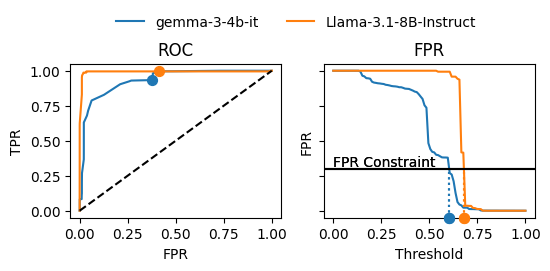

In [40]:
# Arguments
user_id = "marcellobullo"
model_ids = ["google/gemma-3-4b-it", "meta-llama/Llama-3.1-8B-Instruct"]
task = "gsm8k"
sample_id = 2
model_dfs = []

thresholds = np.linspace(0,1, 100)
colors = ["tab:blue", "tab:orange", "tab:green"]

fig, axs = plt.subplots(1, 2, figsize=(6, 2), sharey=True)

stats_dict = {}

for i,model_id in enumerate(model_ids):

    modelname = model_id.split("/")[-1]
    
    # Get the full dataset
    df = get_df(user_id, task, model_id.replace("/", "__"), sample_id)
    s = compute_s(df, "exact_match")
    df = normalize_column(df, "skywork_score", 0, 1)
    df = df.rename(columns={"exact_match": "ground_truth"})
    get_estimated_df_threshold = get_estimated_df_threshold_fn(user_id, task, model_id.replace("/", "__"), sample_id)
    print(s)

    tprs, fprs, shats = [], [], []
    for th in thresholds:

        shat, J, estimated_df = get_estimated_df_threshold(th)
        tpr, fpr = compute_tpr_fpr(estimated_df, "ground_truth", "exact_match")

        tprs.append(tpr)
        fprs.append(fpr)
        shats.append(shat)

    stats_dict[model_id] = {"fprs": fprs, "tprs": tprs, "shats": shats}


    axs[0].plot(fprs, tprs, color=colors[i], label=modelname)

axs[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color="black", linestyle="--")

th_candidates = {
    "google/gemma-3-4b-it": 0.6,
    "meta-llama/Llama-3.1-8B-Instruct": 0.68
}
for i, model_id in enumerate(model_ids):
    get_estimated_df_threshold = get_estimated_df_threshold_fn(user_id, task, model_id.replace("/", "__"), sample_id)
    th = th_candidates[model_id]
    shat, J, estimated_df = get_estimated_df_threshold(th)
    tpr, fpr = compute_tpr_fpr(estimated_df, "ground_truth", "exact_match")
    print(f"{model_id}: fpr={fpr}, tpr={tpr}")

    print(tpr, fpr)

    axs[0].scatter(fpr, tpr, color=colors[i], s=50, zorder=5)
    #plt.text(fpr+0.02, tpr-0.02, f"{model_id}")

axs[0].set_title(f"ROC")

axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")

#axs[0].legend()
axs[0].legend(
    loc="upper center",
    bbox_to_anchor=(1.07, 1.4),  # adjust height as needed
    ncol=2,                      # optional: layout horizontally
    frameon=False                # optional: remove box
)
##########################################################
ax = axs[1]
for model_id in model_ids:
    stats = stats_dict[model_id]
    fprs = np.array(stats["fprs"])
    modelname = model_id.split("/")[-1]
    ax.plot(thresholds, fprs, label=f"{modelname}")
    ax.axhline(0.3, color="k")
    ax.text(0, 0.32, "FPR Constraint", color="k")
    ax.axvline(0.6, ymax=0.3,linestyle=":", color="tab:blue")
    ax.axvline(0.68, ymax=0.3,linestyle=":", color="tab:orange")
    ax.scatter(0.6, -0.05, color="tab:blue", s=50, zorder=10, clip_on=False)
    ax.scatter(0.68, -0.05, color="tab:orange", s=50, zorder=10, clip_on=False)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("FPR")
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f"FPR")
    #ax.legend(fontsize=9, loc="upper right")

plt.savefig(
    f"/home/mb1921/ot-resampling/tasks/gsm8k/results-{sample_id}/plots/roc.pdf",
    dpi=800, 
    bbox_inches="tight",
    #bbox_extra_artists=(legend1, legend2)
)

plt.show()

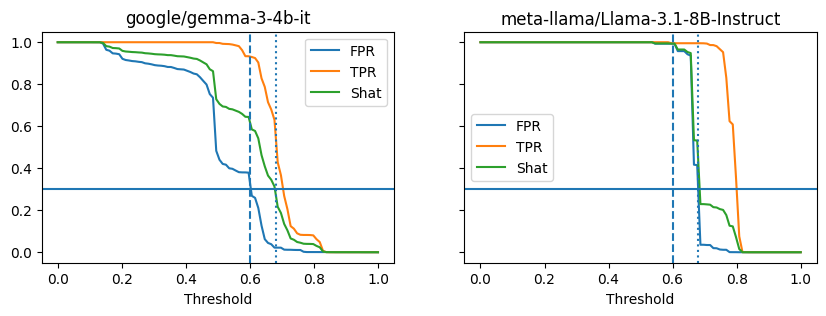

In [41]:
fig, axs = plt.subplots(1, len(model_ids), figsize=(10, 3), sharey=True)
for model_id, ax in zip(model_ids, axs):
    # plot in stats 
    stats = stats_dict[model_id]
    fprs = np.array(stats["fprs"])
    tprs = np.array(stats["tprs"])
    shats = stats["shats"]
    ax.plot(thresholds, fprs, label=f"FPR")
    ax.plot(thresholds, tprs, label=f"TPR")
    ax.plot(thresholds, shats, label=f"Shat")
    ax.axhline(0.3)
    ax.axvline(0.6, linestyle="--")
    ax.axvline(0.68, linestyle=":")
    #ax.plot(thresholds, fprs-tprs, label="J")
    ax.set_title(f"{model_id}")
    ax.set_xlabel("Threshold")
    ax.legend()
plt.show()

# Reward and Computational Complexity

0.5542380222835613
0.5803974492088104


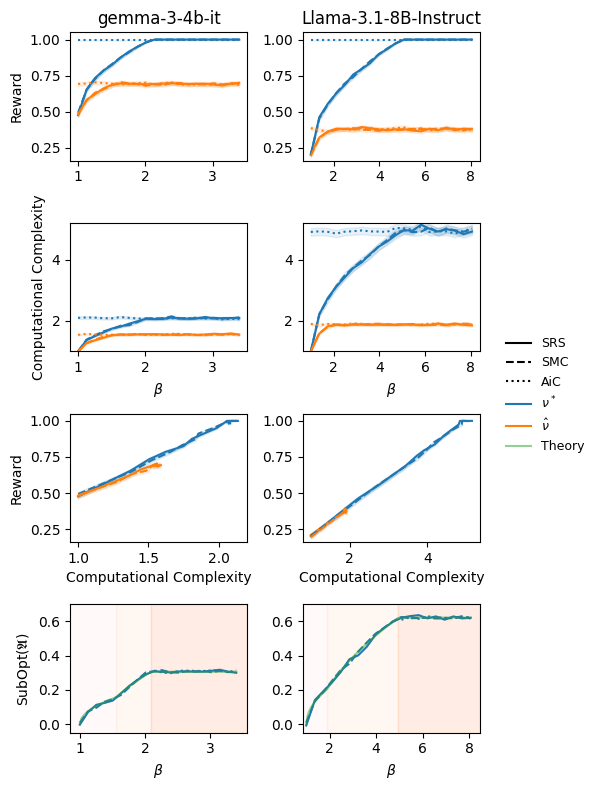

In [46]:
user_id = "marcellobullo"
model_ids = ["google/gemma-3-4b-it", "meta-llama/Llama-3.1-8B-Instruct"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta_threshold/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-th.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)


methods = df["method"].unique()
modes = df["mode"].unique()

linestyles={
    "SRS": "-",
    "SMC": "--",
    "AiC": ":"
}

colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

fig, axs = plt.subplots(4, len(model_ids), figsize=(5, 8))


for ax,model_id in zip(axs[0], model_ids):
    modelname = model_id.split("/")[-1]
    for method in methods:
        for mode in modes:
        
            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

            ax.plot(plot_df["beta"], plot_df["reward"], label=method, linestyle=linestyles[method], color=colors[mode])
            ax.set_title(modelname)

            # Add shaded area for standard deviation
            ax.fill_between(
                plot_df["beta"],
                plot_df["reward"] - 1.96*plot_df["reward_std"]/np.sqrt(5000),
                plot_df["reward"] + 1.96*plot_df["reward_std"]/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )
    ax.set_ylim(0.16, 1.05)
    #ax.set_xlabel(r"$\beta$")

axs[0][0].set_ylabel("Reward")
#axs[0][-2].legend(ncols=2)
##########################################################################################################################################################
for ax,model_id in zip(axs[1], model_ids):
    for method in methods:
        for mode in modes:
        
            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

            shat = plot_df["s"].iloc[0]
            #ax.axhline(1/shat, color=colors[mode])
            ax.plot(plot_df["beta"], plot_df["iter"], label=method, linestyle=linestyles[method], color=colors[mode])
            #ax.set_title(model_id.split("/")[-1])

            # Add shaded area for standard deviation
            ax.fill_between(
                plot_df["beta"],
                plot_df["iter"] - 1.96*plot_df["iter_std"]/np.sqrt(5000),
                plot_df["iter"] + 1.96*plot_df["iter_std"]/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )
    ax.set_ylim(1, 5.2)
    ax.set_xlabel(r"$\beta$")
axs[1][0].set_ylabel("Computational Complexity")

##########################################################################################################################################################
for ax,model_id in zip(axs[2], model_ids):
    modelname = model_id.split("/")[-1]
    for method in methods:
        for mode in modes:
        
            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]
            
            idx = plot_df["iter"].argsort()
            iters_sorted = plot_df["iter"].iloc[idx]
            rewards_sorted = plot_df["reward"].iloc[idx]
            stds = plot_df["reward_std"].iloc[idx]
            ax.plot(iters_sorted, rewards_sorted, label=method, linestyle=linestyles[method], color=colors[mode])
            #ax.set_title(modelname)

            stds = plot_df["reward_std"].iloc[idx]
            # Add shaded area for standard deviation
            ax.fill_between(
                iters_sorted,
                rewards_sorted - 1.96*stds/np.sqrt(5000),
                rewards_sorted + 1.96*stds/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )
    ax.set_ylim(0.16, 1.05)
    ax.set_xlabel(r"Computational Complexity")
axs[2][0].set_ylabel("Reward")


# Manual legend entries for methods (line styles)
method_handles = [
    Line2D([0], [0], color="black", linestyle=linestyles[method], label=method)
    for method in methods
]

# Manual legend entries for modes (colors)
labels = {
    "ground_truth": r"$\nu^*$",
    "estimate": r"$\hat{\nu}$"
}
mode_handles = [
    Line2D([0], [0], color=colors[mode], linestyle="-", label=labels[mode])
    for mode in modes
]

# Add theory handle (green dashed line like in your plot)
theory_handle = Line2D([0], [0], color="tab:green", linestyle="-", alpha=0.5, label="Theory")

# Combine both legends
all_handles = method_handles + mode_handles + [theory_handle]
all_labels = [h.get_label() for h in all_handles]

# Place legend to the right of the figure
fig.legend(
    handles=all_handles,
    labels=all_labels,
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),  # adjust x/y position
    frameon=False,
    fontsize=9,
    title="",
    title_fontproperties={'weight': 'bold'}
)





#########################################################################################################
subopt_idx = 3
for ax,model_id in zip(axs[subopt_idx], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["J"].iloc[0]
    )
    print(J)

    for method in methods:   
        if method=="AiC":
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]=="SRS")
            ]
        else:
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

        estimated_df = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]==method)
        ]

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn(s, shat, J)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]

        suboptimality = gt_df["reward"].values - estimated_df["reward"].values

        if method=="AiC":
            mask = gt_df["beta"] >= 1/s
            ax.plot(gt_df.loc[mask, "beta"], suboptimality[mask], label=method, linestyle=linestyles[method], color="tab:blue")
        else:
            ax.plot(gt_df["beta"], suboptimality, label=method, linestyle=linestyles[method], color="tab:blue")
        #ax.set_title(model_id.split("/")[-1])

        idx = estimated_df["iter"].argsort()
        iters_sorted = estimated_df["iter"].iloc[idx]
        suboptimality_sorted = suboptimality[idx]

    max_beta = np.max(betas)
    ax.axvspan(-1, min(1/s, 1/shat), color="mistyrose", alpha=0.2)
    ax.axvspan(min(1/s, 1/shat), max(1/s, 1/shat), color="peachpuff", alpha=0.2)
    ax.axvspan(max(1/s, 1/shat), max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.85, max_beta*1.05)
    ax.set_ylim(-0.05, 0.7)
    ax.set_xlabel(r"$\beta$")


    ax.plot(betas, subopt_theory, label="theory", linestyle="-", color="tab:green", alpha=0.5)    
    



axs[subopt_idx][0].set_ylabel(r"${\rm SubOpt}(\mathfrak{A})$")





plt.tight_layout()
plt.savefig(
    f"/home/mb1921/ot-resampling/tasks/gsm8k/results-{sample_id}/plots/reward_complexity_threshold.pdf",
    dpi=800, 
    bbox_inches="tight",
    #bbox_extra_artists=(legend1, legend2)
)

plt.show()




0.581771978478461
0.9592110679692072


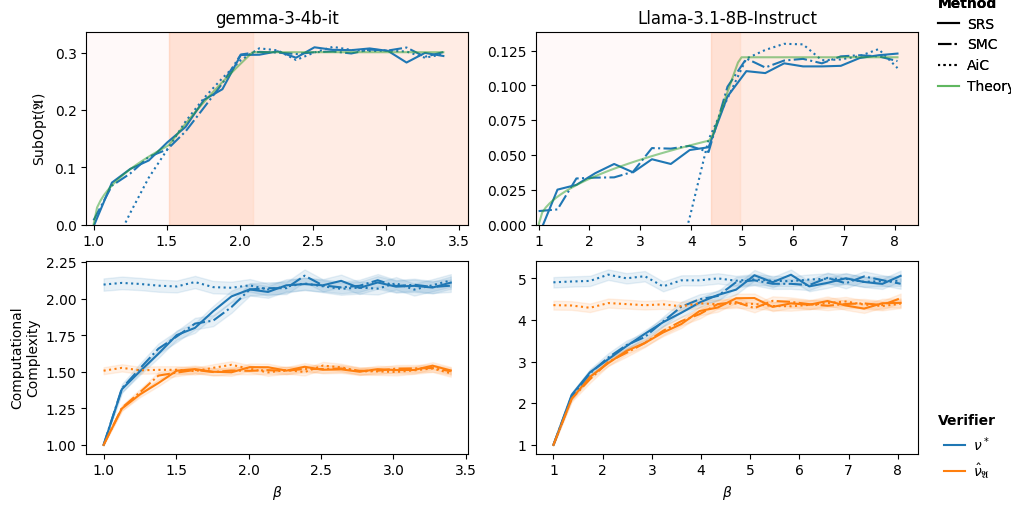

In [10]:
def get_subopt_theory_fn(s, shat, J):
    def subopt_theory_fn(beta):        
        OTC = otc(beta, s) 
        if beta <= min(1/s, 1/shat):
            suboptimality = OTC*(1-math.sqrt((s*(1-s))/(shat*(1-shat)))*J)
        elif beta <= 1/s and beta > 1/shat:
            suboptimality = OTC*(1- (1/shat)*math.sqrt((s*(1-s))/(beta-1))*J)
        elif beta > 1/s and beta <= 1/shat:
            suboptimality = OTC*(1-math.sqrt((beta - 1)/(shat*(1-shat)))*s*J)
        else:
            suboptimality = OTC*(1-(s/shat)*J)
        return suboptimality
    return subopt_theory_fn


user_id = "marcellobullo"
model_ids = ["google/gemma-3-4b-it", "meta-llama/Llama-3.1-8B-Instruct"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta_threshold/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-th.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)

methods = df["method"].unique()
#methods = ["AiC"]

linestyles={
    "SRS": "-",
    "SMC": "-.",
    "AiC": ":"
}

colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

fig, axs = plt.subplots(2, len(model_ids), figsize=(10, 5), sharey=False, sharex=False, constrained_layout=True)

for ax,model_id in zip(axs[0], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["J"].iloc[0]
    )
    print(J)

    for method in methods:   
        if method=="AiC":
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]=="SRS")
            ]
        else:
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

        estimated_df = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]==method)
        ]

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn(s, shat, J)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]

        suboptimality = gt_df["reward"].values - estimated_df["reward"].values

        if method=="AiC":
            mask = gt_df["beta"] >= (1/shat - 1)
            ax.plot(gt_df.loc[mask, "beta"], suboptimality[mask], label=method, linestyle=linestyles[method], color="tab:blue")
        else:
            ax.plot(gt_df["beta"], suboptimality, label=method, linestyle=linestyles[method], color="tab:blue")
        ax.set_title(model_id.split("/")[-1])

        idx = estimated_df["iter"].argsort()
        iters_sorted = estimated_df["iter"].iloc[idx]
        suboptimality_sorted = suboptimality[idx]

    max_beta = np.max(betas)
    ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)


    ax.plot(betas, subopt_theory, label="theory", linestyle="-", color="tab:green", alpha=0.5)    
    ax.set_ylim(0)



axs[0][0].set_ylabel(r"${\rm SubOpt}(\mathfrak{A})$")

# Build manual legend
method_handles = [
    Line2D([0], [0], color="black", linestyle=ls, label=method)
    for i, (method, ls) in enumerate(linestyles.items())
]

# Add theory handle (green dashed line like in your plot)
theory_handle = Line2D([0], [0], color="tab:green", linestyle="-", alpha=0.5, label="Theory")

# Combine methods + theory
method_handles_with_theory = method_handles + [theory_handle]

# Place two legends: one for methods, one for modes
legend1 = axs[0][-1].legend(
    handles=method_handles_with_theory, 
    title="Method", 
    ncols=1,
    loc="upper left", 
    bbox_to_anchor=(1.02, 1.25), 
    frameon=False, 
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
axs[0][-1].add_artist(legend1)  # keep the first legend when adding the second

legend1._legend_box.align = "left"

#######################################################################################################################################

for ax, model_id in zip(axs[1], model_ids):
    for method in methods:
        for mode in modes:

            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"] == method)
            ]

            shat = plot_df["s"].iloc[0]

            # Plot mean line
            ax.plot(
                plot_df["beta"],
                plot_df["iter"],
                label=method,
                linestyle=linestyles[method],
                color=colors[mode]
            )

            # Add shaded area for standard deviation
            ax.fill_between(
                plot_df["beta"],
                plot_df["iter"] - 1.96*plot_df["iter_std"]/np.sqrt(5000),
                plot_df["iter"] + 1.96*plot_df["iter_std"]/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )

    ax.set_xlabel(r"$\beta$")
    
axs[1][0].set_ylabel("Computational\nComplexity")

# Build manual legend
method_handles = [
    Line2D([0], [0], color="black", linestyle=ls, label=method)
    for i, (method, ls) in enumerate(linestyles.items())
]

mode_titles = [r"$\nu^*$", r"$\hat{\nu}_{\mathfrak{A}}$"]
mode_handles = [
    Line2D([0], [0], color=clr, linestyle="-", label=mode_titles[i])
    for i, (mode, clr) in enumerate(colors.items())
]

# Place two legends: one for methods, one for modes
legend1 = axs[1][-1].legend(
    handles=method_handles + mode_handles, 
    title="",#r"Algorithm $\mathfrak{A}$", 
    ncols=1,
    loc="upper left", 
    bbox_to_anchor=(1.02, 1.25), 
    frameon=False, 
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
#axs[1][-1].add_artist(legend1)  # keep the first legend when adding the second
legend1._legend_box.align = "left"

legend2 = axs[1][-1].legend(
    handles=mode_handles, 
    ncols=1,
    title="Verifier",
    loc="lower left", 
    bbox_to_anchor=(1.02, -0.2), 
    frameon=False,
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
# legend2._legend_box.align = "left"

#plt.tight_layout()
# plt.savefig(
#     "/home/mb1921/ot-resampling/tasks/gsm8k/results-2/plots/exp_fig1.pdf",
#     dpi=800, 
#     bbox_inches="tight",
#     bbox_extra_artists=(legend1, legend2)
# )
plt.show()




,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J
0,1.000000,google/gemma-3-4b-it,0.478547,0.4760,0.499424,1.0000,0.000000,SRS,ground_truth,0.608160
1,1.000000,google/gemma-3-4b-it,0.478547,0.4930,0.499951,1.0000,0.000000,SMC,ground_truth,0.608160
2,1.000000,google/gemma-3-4b-it,0.478547,1.0000,0.000000,2.0976,1.522785,AiC,ground_truth,0.608160
3,1.000000,google/gemma-3-4b-it,0.659208,0.4792,0.499567,1.0000,0.000000,SRS,estimate,0.608160
4,1.000000,google/gemma-3-4b-it,0.659208,0.4852,0.499781,1.0000,0.000000,SMC,estimate,0.608160
...,...,...,...,...,...,...,...,...,...,...
235,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,1.0000,0.000000,4.8718,4.366482,SMC,ground_truth,0.581928
236,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,1.0000,0.000000,4.9454,4.386937,AiC,ground_truth,0.581928
237,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.227796,0.8772,0.328207,4.4138,3.891088,SRS,estimate,0.581928
238,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.227796,0.8826,0.321896,4.5260,3.958045,SMC,estimate,0.581928


In [41]:
s = 0.478547
shat = 0.659208	
J = 0.608160


TPR = shat + (1 - s) * J
FPR = shat - s * J

reward = (s/shat)*TPR
reward

0.7087628131999834

-0.35790976414954045

In [57]:
J = 0.581928
s = 0.201738
shat = 0.227796


TPR = shat + (1 - s) * J
FPR = shat - s * J

reward = (s/shat)*TPR
print("reward", reward)

J_tilde = -(0.3-shat)/s
J_tilde
print("J_tilde", J_tilde)

# (1-(s*J/shat))*otc(8, 0.659208	 )
TPR

reward 0.6131304595738222
J_tilde -0.35790976414954045


0.6923270091360001

0.5819267666119188

In [ ]:
shat = s

In [ ]:
J = (-0.3 +shat)/s
J

0.110399009136

In [40]:
TPR-0.3

0.3923270091360001

In [37]:

(s/shat)*TPR

0.6131304595738222

In [61]:
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J
0,1.000000,google/gemma-3-4b-it,0.478547,0.4760,0.499424,1.0000,0.000000,SRS,ground_truth,0.608160
1,1.000000,google/gemma-3-4b-it,0.478547,0.4930,0.499951,1.0000,0.000000,SMC,ground_truth,0.608160
2,1.000000,google/gemma-3-4b-it,0.478547,1.0000,0.000000,2.0976,1.522785,AiC,ground_truth,0.608160
3,1.000000,google/gemma-3-4b-it,0.659208,0.4792,0.499567,1.0000,0.000000,SRS,estimate,0.608160
4,1.000000,google/gemma-3-4b-it,0.659208,0.4852,0.499781,1.0000,0.000000,SMC,estimate,0.608160
...,...,...,...,...,...,...,...,...,...,...
235,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,1.0000,0.000000,4.8718,4.366482,SMC,ground_truth,0.581928
236,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,1.0000,0.000000,4.9454,4.386937,AiC,ground_truth,0.581928
237,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.227796,0.8772,0.328207,4.4138,3.891088,SRS,estimate,0.581928
238,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.227796,0.8826,0.321896,4.5260,3.958045,SMC,estimate,0.581928


In [60]:
gt_col = "ground_truth"
pred_col = "exact_match"
tp = ((df[gt_col] == 1) & (df[pred_col] == 1))
tn = ((df[gt_col] == 0) & (df[pred_col] == 0))
fp = ((df[gt_col] == 0) & (df[pred_col] == 1))
fn = ((df[gt_col] == 1) & (df[pred_col] == 0))

KeyError: 'ground_truth'

In [106]:
1/0.227796

4.389892711022143

0.5819281076105955


TypeError: 'Axes' object is not subscriptable

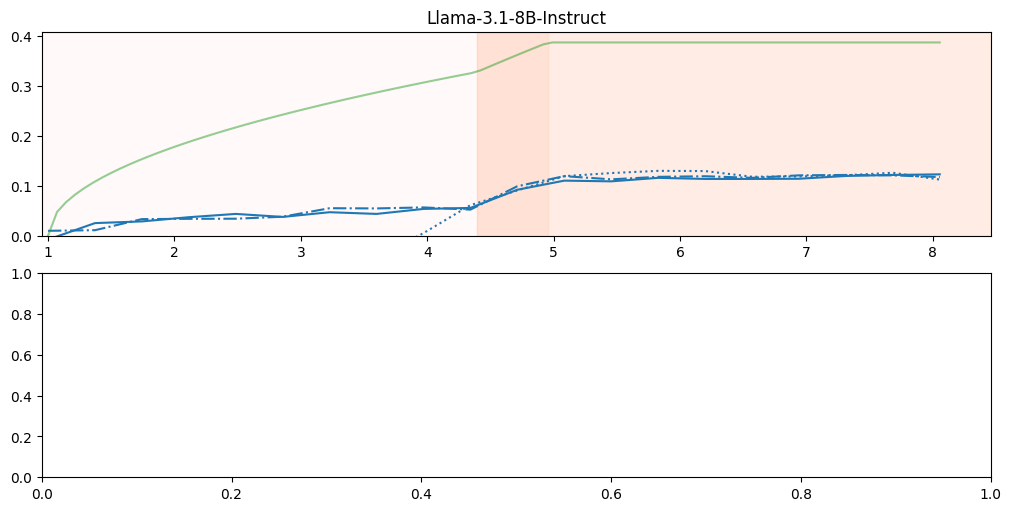

In [52]:
user_id = "marcellobullo"
model_ids = ["meta-llama/Llama-3.1-8B-Instruct"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta_threshold/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-th_old.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)

methods = df["method"].unique()
#methods = ["AiC"]

linestyles={
    "SRS": "-",
    "SMC": "-.",
    "AiC": ":"
}

colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

fig, axs = plt.subplots(2, len(model_ids), figsize=(10, 5), sharey=False, sharex=False, constrained_layout=True)

for ax,model_id in zip(axs, model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["J"].iloc[0]
    )
    print(J)
    #J = 0.39

    for method in methods:   
        if method=="AiC":
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]=="SRS")
            ]
        else:
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

        estimated_df = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]==method)
        ]

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn(s, shat, J)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]

        suboptimality = gt_df["reward"].values - estimated_df["reward"].values

        if method=="AiC":
            mask = gt_df["beta"] >= (1/shat - 1)
            ax.plot(gt_df.loc[mask, "beta"], suboptimality[mask], label=method, linestyle=linestyles[method], color="tab:blue")
        else:
            ax.plot(gt_df["beta"], suboptimality, label=method, linestyle=linestyles[method], color="tab:blue")
        ax.set_title(model_id.split("/")[-1])

        idx = estimated_df["iter"].argsort()
        iters_sorted = estimated_df["iter"].iloc[idx]
        suboptimality_sorted = suboptimality[idx]

    max_beta = np.max(betas)
    ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)


    ax.plot(betas, subopt_theory, label="theory", linestyle="-", color="tab:green", alpha=0.5)    
    ax.set_ylim(0)



axs[0][0].set_ylabel(r"${\rm SubOpt}(\mathfrak{A})$")

# Build manual legend
method_handles = [
    Line2D([0], [0], color="black", linestyle=ls, label=method)
    for i, (method, ls) in enumerate(linestyles.items())
]

# Add theory handle (green dashed line like in your plot)
theory_handle = Line2D([0], [0], color="tab:green", linestyle="-", alpha=0.5, label="Theory")

# Combine methods + theory
method_handles_with_theory = method_handles + [theory_handle]

# Place two legends: one for methods, one for modes
legend1 = axs[0][-1].legend(
    handles=method_handles_with_theory, 
    title="Method", 
    ncols=1,
    loc="upper left", 
    bbox_to_anchor=(1.02, 1.25), 
    frameon=False, 
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
axs[0][-1].add_artist(legend1)  # keep the first legend when adding the second

legend1._legend_box.align = "left"

In [ ]:
m = 


In [29]:
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J
0,1.000000,meta-llama/Llama-3.1-8B-Instruct,0.201738,0.2014,0.401046,1.0000,0.000000,SRS,ground_truth,0.581928
1,1.000000,meta-llama/Llama-3.1-8B-Instruct,0.201738,0.2030,0.402233,1.0000,0.000000,SMC,ground_truth,0.581928
2,1.000000,meta-llama/Llama-3.1-8B-Instruct,0.201738,1.0000,0.000000,4.9070,4.507766,AiC,ground_truth,0.581928
3,1.000000,meta-llama/Llama-3.1-8B-Instruct,0.227796,0.2092,0.406737,1.0000,0.000000,SRS,estimate,0.581928
4,1.000000,meta-llama/Llama-3.1-8B-Instruct,0.227796,0.1932,0.394809,1.0000,0.000000,SMC,estimate,0.581928
...,...,...,...,...,...,...,...,...,...,...
115,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,1.0000,0.000000,4.8718,4.366482,SMC,ground_truth,0.581928
116,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,1.0000,0.000000,4.9454,4.386937,AiC,ground_truth,0.581928
117,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.227796,0.8772,0.328207,4.4138,3.891088,SRS,estimate,0.581928
118,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.227796,0.8826,0.321896,4.5260,3.958045,SMC,estimate,0.581928
